# "American sign language classifier from scratch"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [classifier, scratch, vision]
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
df = pd.read_csv('/code/datasets/mnist_sign/sign_mnist_train.csv')
classes = [3, 1, 23, 22]
df = df[df.label.isin(classes)]
train_df = df.sample(frac=0.8, random_state=100)
test_df = df.drop(train_df.index)

train_df.shape, test_df.shape

((3676, 785), (919, 785))

In [3]:
def get_labels(df):
    return tensor(df.iloc[:, 0].values).unsqueeze(1)

def get_image_tensors(df):
    return torch.stack([tensor(image_array)/255. for image_array in df.iloc[:, 1:].values])

def get_dataset(df):
    return zip(get_labels(df), get_image_tensors(df))

In [4]:
dataset = get_dataset(df)

tensor([3])
tensor([22])


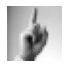

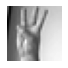

In [5]:
for label, image_tensor in list(dataset)[:2]:
    print(label)
    show_image(torch.reshape(image_tensor, (28, 28)), cmap='gray')

### Initialize weights

In [6]:
def get_random_weights(rows, cols):
    return torch.randn(rows, cols).requires_grad_()

In [7]:
weights = get_random_weights(28*28, len(classes))
bias = get_random_weights(1, len(classes))
weights.shape, bias.shape

(torch.Size([784, 4]), torch.Size([1, 4]))

### Get Predictions 

In [8]:
image_tensors = get_image_tensors(train_df)
image_tensors.shape, weights.shape

(torch.Size([3676, 784]), torch.Size([784, 4]))

In [9]:
def get_predictions(image_tensors, weights, bias):
    return image_tensors@weights + bias

In [10]:
predictions = get_predictions(image_tensors, weights, bias)
predictions.shape

torch.Size([3676, 4])

Check initial accuracy

In [11]:
test_image_tensors, test_labels = get_image_tensors(test_df), get_labels(test_df)
test_preds = get_predictions(test_image_tensors, weights, bias)
pred_classes = torch.argmax(test_preds, dim=1)

# This will select the class value based on index of pred_classes
preds = tensor(classes).gather(0, pred_classes)
(preds == test_labels).float().mean() 

# Random weights are ~26% accurate

tensor(0.2666)

### Calculate loss

In [12]:
labels = get_labels(train_df)
# get each label class
target_classes = tensor([classes.index(c) for c in labels.view(-1)])
target_classes[:5]

tensor([2, 0, 3, 0, 3])

In [13]:
# softmax function turns the predictions into probabilities and amplifies the predictions 
def softmax(predictions):
    return torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True)
# pytorch equivalent
activations_py = torch.softmax(predictions, dim=1)
activations = softmax(predictions)

activations[0], activations_py[0]

(tensor([1.0000e+00, 4.5578e-15, 1.8615e-18, 9.9750e-14],
        grad_fn=<SelectBackward>),
 tensor([1.0000e+00, 4.5578e-15, 1.8615e-18, 9.9750e-14],
        grad_fn=<SelectBackward>))

In [14]:
# mean of corresponding activations based on the target class
loss = activations[range(len(target_classes)), target_classes].mean()
# pytorch equivalent 
loss_py = -F.nll_loss(activations, target_classes)

loss, loss_py

(tensor(0.2589, grad_fn=<MeanBackward0>),
 tensor(0.2589, grad_fn=<NegBackward>))

In [15]:
# as softmax function turns predictions into probabilities, each activation is bounded between (0, 1) hence our model considers 0.900 and 0.999 as the same but the second prediction is 100 times more confident hence we use log to amplify the domain to (-inf, inf)

In [16]:
# softmax + log + negative_loss_likelyhood = cross_entropy_loss: this can be used for classification problems
def cross_entropy_loss(predictions, target_classes): 
    activations = softmax(predictions)
    activations_log = torch.log(activations)
    loss = activations_log[range(len(target_classes)), target_classes].mean()
    return -loss
# pytorch equivalent
cross_entropy_loss_py = F.cross_entropy(predictions, target_classes)

cross_entropy_loss(predictions, target_classes), cross_entropy_loss_py

(tensor(15.8286, grad_fn=<NegBackward>),
 tensor(15.8286, grad_fn=<NllLossBackward>))

### Optimise weights

In [17]:
learning_rate = 1e-3

In [18]:
def train(image_tensors, weights, bias, learning_rate, no_of_iterations):
    for i in range(no_of_iterations):
        predictions = get_predictions(image_tensors, weights, bias)
        loss = cross_entropy_loss(predictions, target_classes)
        print(f'Iteration {i}, Loss = {loss}')
        loss.backward()
        weights.data = weights.data - weights.grad * learning_rate
        bias.data = bias.data - bias.grad * learning_rate
        weights.grad.zero_()
        bias.grad.zero_()

In [19]:
train(image_tensors, weights, bias, learning_rate=10, no_of_iterations=1000)

Iteration 0, Loss = 15.828592300415039
Iteration 1, Loss = nan
Iteration 2, Loss = nan
Iteration 3, Loss = nan
Iteration 4, Loss = nan
Iteration 5, Loss = nan
Iteration 6, Loss = nan
Iteration 7, Loss = nan
Iteration 8, Loss = nan
Iteration 9, Loss = nan
Iteration 10, Loss = nan
Iteration 11, Loss = nan
Iteration 12, Loss = nan
Iteration 13, Loss = nan
Iteration 14, Loss = nan
Iteration 15, Loss = nan
Iteration 16, Loss = nan
Iteration 17, Loss = nan
Iteration 18, Loss = nan
Iteration 19, Loss = nan
Iteration 20, Loss = nan
Iteration 21, Loss = nan
Iteration 22, Loss = nan
Iteration 23, Loss = nan
Iteration 24, Loss = nan
Iteration 25, Loss = nan
Iteration 26, Loss = nan
Iteration 27, Loss = nan
Iteration 28, Loss = nan
Iteration 29, Loss = nan
Iteration 30, Loss = nan
Iteration 31, Loss = nan
Iteration 32, Loss = nan
Iteration 33, Loss = nan
Iteration 34, Loss = nan
Iteration 35, Loss = nan
Iteration 36, Loss = nan
Iteration 37, Loss = nan
Iteration 38, Loss = nan
Iteration 39, Loss =

Iteration 340, Loss = nan
Iteration 341, Loss = nan
Iteration 342, Loss = nan
Iteration 343, Loss = nan
Iteration 344, Loss = nan
Iteration 345, Loss = nan
Iteration 346, Loss = nan
Iteration 347, Loss = nan
Iteration 348, Loss = nan
Iteration 349, Loss = nan
Iteration 350, Loss = nan
Iteration 351, Loss = nan
Iteration 352, Loss = nan
Iteration 353, Loss = nan
Iteration 354, Loss = nan
Iteration 355, Loss = nan
Iteration 356, Loss = nan
Iteration 357, Loss = nan
Iteration 358, Loss = nan
Iteration 359, Loss = nan
Iteration 360, Loss = nan
Iteration 361, Loss = nan
Iteration 362, Loss = nan
Iteration 363, Loss = nan
Iteration 364, Loss = nan
Iteration 365, Loss = nan
Iteration 366, Loss = nan
Iteration 367, Loss = nan
Iteration 368, Loss = nan
Iteration 369, Loss = nan
Iteration 370, Loss = nan
Iteration 371, Loss = nan
Iteration 372, Loss = nan
Iteration 373, Loss = nan
Iteration 374, Loss = nan
Iteration 375, Loss = nan
Iteration 376, Loss = nan
Iteration 377, Loss = nan
Iteration 37

Iteration 685, Loss = nan
Iteration 686, Loss = nan
Iteration 687, Loss = nan
Iteration 688, Loss = nan
Iteration 689, Loss = nan
Iteration 690, Loss = nan
Iteration 691, Loss = nan
Iteration 692, Loss = nan
Iteration 693, Loss = nan
Iteration 694, Loss = nan
Iteration 695, Loss = nan
Iteration 696, Loss = nan
Iteration 697, Loss = nan
Iteration 698, Loss = nan
Iteration 699, Loss = nan
Iteration 700, Loss = nan
Iteration 701, Loss = nan
Iteration 702, Loss = nan
Iteration 703, Loss = nan
Iteration 704, Loss = nan
Iteration 705, Loss = nan
Iteration 706, Loss = nan
Iteration 707, Loss = nan
Iteration 708, Loss = nan
Iteration 709, Loss = nan
Iteration 710, Loss = nan
Iteration 711, Loss = nan
Iteration 712, Loss = nan
Iteration 713, Loss = nan
Iteration 714, Loss = nan
Iteration 715, Loss = nan
Iteration 716, Loss = nan
Iteration 717, Loss = nan
Iteration 718, Loss = nan
Iteration 719, Loss = nan
Iteration 720, Loss = nan
Iteration 721, Loss = nan
Iteration 722, Loss = nan
Iteration 72

In [20]:
test_image_tensors, test_labels = get_image_tensors(test_df), get_labels(test_df)
test_preds = get_predictions(test_image_tensors, weights, bias)
pred_classes = torch.argmax(test_preds, dim=1)

# This will select the class value based on index of pred_classes
preds = tensor(classes).gather(0, pred_classes)
(preds == test_labels).float().mean() 

# Random weights are ~26% accurate

tensor(0.2666)

In [21]:
weights

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], requires_grad=True)